In [154]:
%matplotlib inline 

import pandas as pd

import os
import inspect
import random
import shutil

import json

In [106]:
this_filename = inspect.getframeinfo(inspect.currentframe()).filename
working_path = os.path.dirname(os.path.abspath(this_filename))
data_path = working_path+"/../input/covid-chest-xray"
images_path = data_path+"/images"
data = pd.read_csv(data_path+"/metadata.csv")
print(images_path)

/home/petejb88/mlenv/transfer-learning-image-classifier/working/../input/covid-chest-xray/images


In [4]:
categories = data.finding.unique()
print(categories)

['COVID-19' 'ARDS' 'SARS' 'Pneumocystis' 'Streptococcus' 'No Finding'
 'Chlamydophila' 'E.Coli' 'COVID-19, ARDS' 'Klebsiella' 'Legionella']


Create train, valid, and category FOLDERS

In [14]:
new_folders = ['train', 'valid']

def delete_cat_folders(images_path,new_folders):
    for folder in new_folders:
        try:
            shutil.rmtree(images_path+"/"+folder)
        except:
            print("Folder {} doesn't exist!".format(folder))
    
def make_cat_folders(images_path,categories):
    for folder in new_folders:
        try:
            os.mkdir(images_path+"/"+folder)
        except:
            print('Folder {} already exists!'.format(folder))
        for i, cat in enumerate(categories):
            try:
                os.mkdir(images_path+"/"+folder+"/"+str(i))
            except:
                print("Folder {}/{} already exists!".format(folder,cat))
                
def make_cat_dicts(images_path,categories):
    cat_to_names = {}
    names_to_cat = {}
    for i,cat in enumerate(categories):
            cat_to_names[str(i)] = cat
            names_to_cat[cat] = str(i)
    
    json_object = json.dumps(cat_to_names, indent = 4)
    with open(data_path+"/cat_to_names.json", "w") as outfile:
        outfile.write(json_object)
        
    return cat_to_names, names_to_cat
            



In [12]:
cat_to_names, names_to_cat = make_cat_dicts(images_path,categories)

# Shuffle Images
Now, we shuffle the images into these folders, while classifying them as we go

First, we check to see if any images are missing: (qualitative)

In [16]:
def check_missing(data,images_path):
    not_in_data = []
    in_data = []
    for file in os.listdir(images_path):
        if os.path.isfile(images_path+"/"+file):
            file_data = data[data['filename'] == file]
            if len(file_data) == 0:
                not_in_data.append(file)
            else:
                in_data.append(file)

    return not_in_data, in_data

In [100]:
def list_images_in_data(images_path):
    images = [image for image in os.listdir(images_path) if os.path.isfile(images_path+"/"+image)]
    images_not_in_data = []
    data_not_in_images = []
    for image in images:
        image_data = data[data['filename']==image]
        if len(image_data) == 0:
            images_not_in_data.append(image)
    images_in_data = [image for image in images if (image not in images_not_in_data)]
    for filename in data['filename']:
        if filename not in os.listdir(images_path):
            data_not_in_images.append(filename)
    print("How many in folder: {}, How many not in data: {}, How many in data: {}, How many data not in images: {}".format(
        len(images),
        len(images_not_in_data),
        len(images_in_data),
        len(data_not_in_images)))
    return images, images_in_data, data_not_in_images

### Todo: clean data more at startup 
Noticed a variation in the number of validation photos, coming from 21 missing images and 6 missing data entries.

In [104]:
def shuffle_images(data,images_path,p):
    '''
    Shuffle the images (as symbolic links) into training and validation folders.
    
    Inputs: 
        - p = percentage split into validation
        - data = metadata
        - images = list of images
        - images_path = location of images
        
    Warning: there will always be some variability in the number of validation photos, as there are 
    '''
    
    categories = data.finding.unique()
    delete_cat_folders(images_path,['train', 'valid'])
    make_cat_folders(images_path,categories)
    
    images, images_in_data, data_not_in_images = list_images_in_data(images_path)

    valid_nums = random.sample(range(len(images)),int(len(images_in_data)*p))
    for image in images_in_data:    
        image_data = data[data['filename']==image]
        image_index = image_data.index[0]
        image_finding = image_data['finding'][image_index]
        image_cat = names_to_cat[image_finding]
        if image_index in valid_nums:
            os.symlink(images_path+"/"+image, images_path+"/valid/"+image_cat+"/"+image)
        else:
            os.symlink(images_path+"/"+image, images_path+"/train/"+image_cat+"/"+image)
    
    test(p,images_in_data)

In [169]:
shuffle_images(data,images_path,0.3)

How many in folder: 357, How many not in data: 6, How many in data: 351, How many data not in images: 21
Valid Count: 98, Valid Expected: 0
Valid Wrong Cat: []
Train Count: 253, Train Expected: 2
Train Wrong Cat: []
Total Count: 351, Total Expected: 351


Test that we have shuffled property:

In [63]:
# count the number of validation photos
def test_valid(p):
    count, wrong_cat = test_file_count(images_path+"/valid")                                
    print("Valid Count: {}, Valid Expected: {}".format(count, int(p*len(images_in_data))))
    print("Valid Wrong Cat: {}".format(wrong_cat))
    return count, wrong_cat
    
def test_train(p):
    count, wrong_cat = test_file_count(images_path+"/train")                                
    print("Train Count: {}, Train Expected: {}".format(count, int((1-p)*len(images_in_data))))
    print("Train Wrong Cat: {}".format(wrong_cat))
    return count, wrong_cat
    
def test_file_count(path):
    count = 0
    wrong_cat = []
    for folder in os.listdir(path):
        for image in os.listdir(path+"/"+folder):
            count += 1
            image_data = data[data['filename']==image]
            image_index = image_data.index[0]
            image_finding = image_data['finding'][image_index]
            image_cat = names_to_cat[image_finding]
            if image_cat != folder:
                wrong_cat.append(folder)
    return count, wrong_cat

def test(p,images_in_data):
    valid_count, valid_wrong_cat = test_valid(p)
    train_count, train_wrong_cat = test_train(p)
    print("Total Count: {}, Total Expected: {}".format(valid_count+train_count, len(images_in_data)))

# Create Model

In [147]:
os.symlink(working_path+"/../train.py", working_path+"/train.py")
os.symlink(working_path+"/../predict.py", working_path+"/predict.py")
os.symlink(working_path+"/../model_functions.py", working_path+"/model_functions.py")

In [171]:
from model_functions import *

In [175]:
train_data, valid_data, trainloader, validloader = build_loader(images_path)

In [176]:
model, criterion, optimizer = build_model("alexnet",0.001,[4096,1024],train_data)

In [177]:
model, optimizer, train_losses, valid_losses, accuracy_data = train_model(model,criterion,optimizer,trainloader,validloader,20,2,False)

Epoch 1 starting...
Epoch 1
Running Loss: 5.791832685470581
Validating Accuracy: 0.6764705777168274
Validating Loss: 2.0222995281219482
Epoch 1
Running Loss: 3.1493064165115356
Validating Accuracy: 0.6764705777168274
Validating Loss: 2.0920863151550293
Epoch 2 starting...
Epoch 2
Running Loss: 1.2701753973960876
Validating Accuracy: 0.6764705777168274
Validating Loss: 1.8157083988189697
Epoch 2
Running Loss: 2.37005352973938
Validating Accuracy: 0.6764705777168274
Validating Loss: 1.925265908241272
Epoch 3 starting...
Epoch 3
Running Loss: 1.3389385342597961
Validating Accuracy: 0.6764705777168274
Validating Loss: 2.2100186347961426
Epoch 3
Running Loss: 1.5002155303955078
Validating Accuracy: 0.6764705777168274
Validating Loss: 1.9272074699401855
Epoch 4 starting...
Epoch 4
Running Loss: 1.1789920330047607
Validating Accuracy: 0.6764705777168274
Validating Loss: 1.5279607772827148
Epoch 4
Running Loss: 1.020022690296173
Validating Accuracy: 0.6764705777168274
Validating Loss: 1.455757

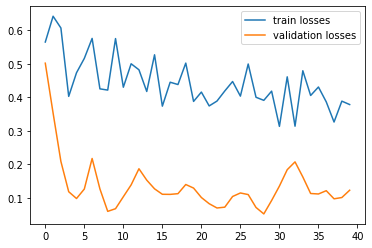

In [168]:
plot_stats(train_losses, valid_losses)